## AlexNet 구현

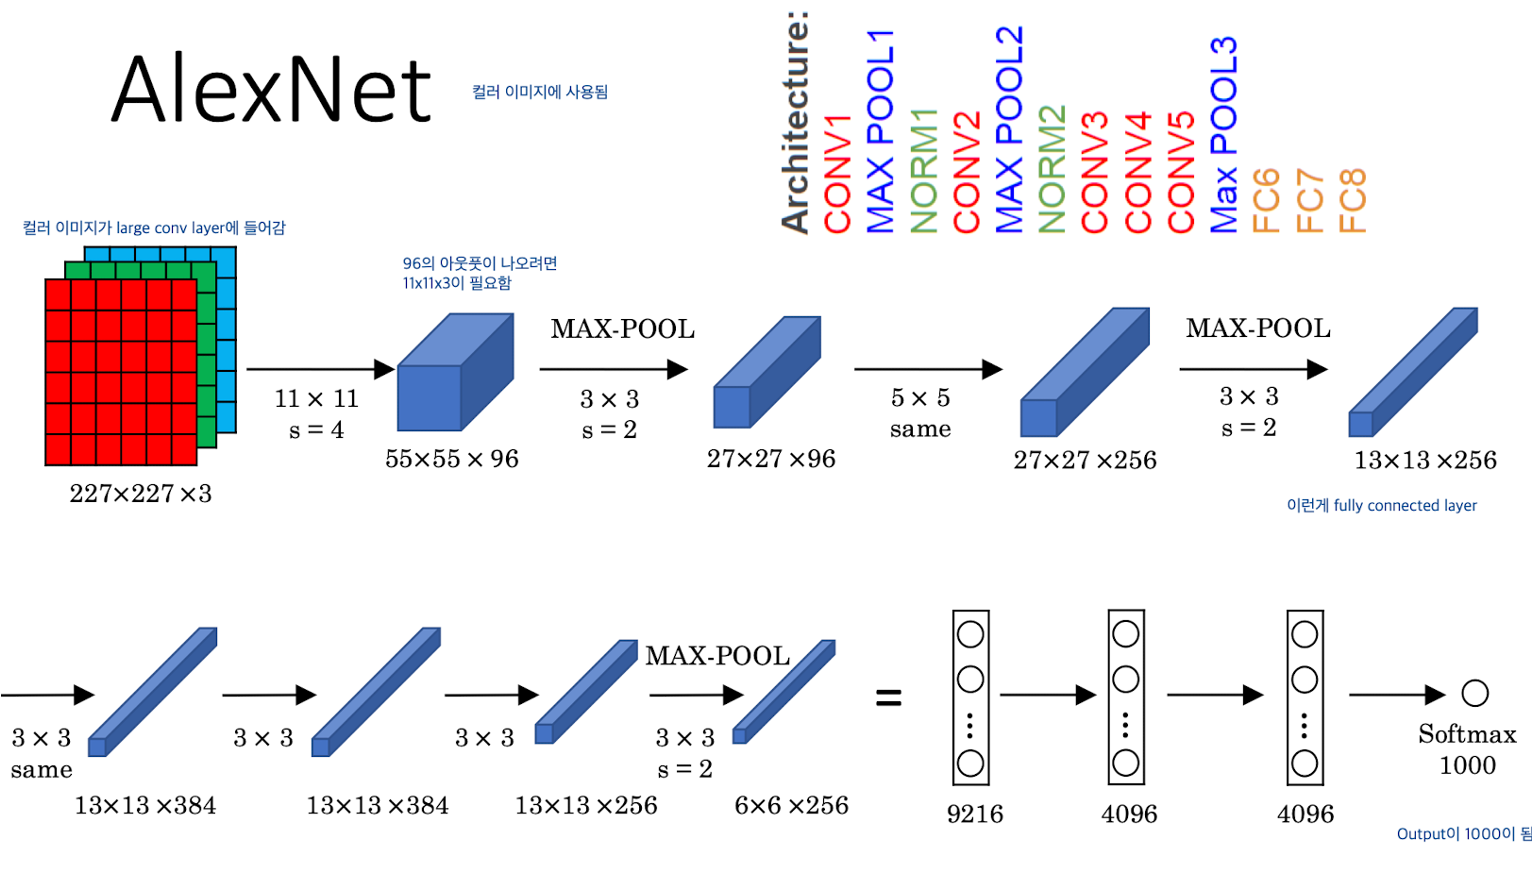

당시 GTX 580 3 GB 두 장으로만 훈련 가능해 모델 파라미터를 반씩 나눠 실행했다. 현대 GPU에는 10 GB 이상 메모리가 흔해 통합 구조가 더 단순·빠르다. PyTorch torchvision.models.alexnet은 저자가 단일 GPU용으로 다시 공개한 Caffe 모델을 그대로 옮긴 버전

In [5]:
import torch
import torch.nn as nn

class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()

        self.features = nn.Sequential(
            # 첫 번째 Convolution: 입력 채널 3, 출력 채널 64, 커널 크기 11, stride 4, padding 2
            nn.Conv2d(3,64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            # 두 번째 Convolution: 입력 64, 출력 192, 커널 크기 5, padding 2
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            # 세 번째 Convolution: 입력 192, 출력 384, 커널 크기 3, padding 1
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(),

            # 네 번째 Convolution: 입력 384, 출력 256, 커널 크기 3, padding 1
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),

            # 다섯 번째 Convolution: 입력 256, 출력 256, 커널 크기 3, padding 1
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        # AdaptiveAvgPool를 사용하여 임의의 입력 크기에 대해 고정된 출력 크기 (6, 6)를 만듭니다.
        self.avgpool = nn.AdaptiveAvgPool2d((6,6))
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        
        return x


if __name__ == '__main__':
    model = AlexNet(num_classes=1000)
    print(model)
    
    x = torch.randn(64, 3, 320, 320)
    output = model(x)
    print(output.shape)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4

파이토치에서 제공하는 알렉스넷 모델 : https://pytorch.org/vision/main/models/generated/torchvision.models.alexnet.html

https://docs.pytorch.org/vision/main/_modules/torchvision/models/alexnet.html

  

위의 모델 빌더는 **weights(가중치) 매개변수**로 다음 값을 허용합니다.  
`AlexNet_Weights.DEFAULT`는 `AlexNet_Weights.IMAGENET1K_V1`과 동일합니다.  
또한 문자열을 사용할 수도 있으며, 예를 들어 `weights='DEFAULT'` 또는 `weights='IMAGENET1K_V1'`처럼 지정할 수 있습니다.  

---

### **AlexNet_Weights.IMAGENET1K_V1:**
이 가중치는 논문의 결과를 간단한 학습 방법을 사용하여 거의 동일하게 재현한 것입니다.  
또한 `AlexNet_Weights.DEFAULT`로도 제공됩니다.  

#### **모델 성능 (ImageNet-1K 기준)**
- **Top-1 정확도 (acc@1):** 56.522%  
- **Top-5 정확도 (acc@5):** 79.066%  
- **총 파라미터 수:** 61,100,840  
- **최소 입력 이미지 크기:** 높이 63px, 너비 63px  
- **분류 가능한 카테고리:**  
  - 예시: **tench(숭어), goldfish(금붕어), great white shark(백상아리)** 등 (총 1000개 중 997개 생략)  
- **학습 방법 (recipe):** 링크 제공  
- **연산량 (GFLOPS):** 0.71 GFLOPS (1초당 약 7,100만 개의 부동소수점 연산 수행)  
- **모델 파일 크기:** 233.1MB  

---

### **추론(Inference) 변환**
`AlexNet_Weights.IMAGENET1K_V1.transforms`에서 제공하는 변환(transforms)은 다음과 같은 전처리 과정을 수행합니다.  

1. **입력 형식:**  
   - `PIL.Image` 객체  
   - 배치(batch) 형식: `(B, C, H, W)`  
   - 단일(single) 이미지 형식: `(C, H, W)`

2. **이미지 전처리 과정:**  
   - **리사이징(resizing):**  
     - **크기:** `resize_size=[256]`  
     - **보간법(interpolation):** `InterpolationMode.BILINEAR(양선형 보간법)` 사용  
   - **중앙 크롭(central crop):**  
     - **크기:** `crop_size=[224]`  
   - **정규화(normalization):**  
     - 픽셀 값 범위 변환: `[0.0, 1.0]`로 리스케일  
     - 평균(mean) 및 표준 편차(std) 사용하여 정규화  
       - **평균(mean):** `[0.485, 0.456, 0.406]`  
       - **표준 편차(std):** `[0.229, 0.224, 0.225]`  

이러한 전처리는 모델이 학습된 데이터와 동일한 입력 형태를 유지하도록 하기 위해 필요합니다.

In [8]:
from torchvision import models

model = models.alexnet(weights='AlexNet_Weights.IMAGENET1K_V1')
model

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\amy/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:03<00:00, 61.2MB/s] 


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [9]:
from torchinfo import summary
summary(model, (1,3,224,224), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [1, 1000]                 --
├─Sequential: 1-1                        [1, 256, 6, 6]            --
│    └─Conv2d: 2-1                       [1, 64, 55, 55]           23,296
│    └─ReLU: 2-2                         [1, 64, 55, 55]           --
│    └─MaxPool2d: 2-3                    [1, 64, 27, 27]           --
│    └─Conv2d: 2-4                       [1, 192, 27, 27]          307,392
│    └─ReLU: 2-5                         [1, 192, 27, 27]          --
│    └─MaxPool2d: 2-6                    [1, 192, 13, 13]          --
│    └─Conv2d: 2-7                       [1, 384, 13, 13]          663,936
│    └─ReLU: 2-8                         [1, 384, 13, 13]          --
│    └─Conv2d: 2-9                       [1, 256, 13, 13]          884,992
│    └─ReLU: 2-10                        [1, 256, 13, 13]          --
│    └─Conv2d: 2-11                      [1, 256, 13, 13]         

In [24]:
import requests

url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"

response = requests.get(url)

imagenet_classes = response.text.strip().split('\n')
print(imagenet_classes)

print(len(imagenet_classes))

['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house finch', 'junco', 'indigo bunting', 'robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'water ouzel', 'kite', 'bald eagle', 'vulture', 'great grey owl', 'European fire salamander', 'common newt', 'eft', 'spotted salamander', 'axolotl', 'bullfrog', 'tree frog', 'tailed frog', 'loggerhead', 'leatherback turtle', 'mud turtle', 'terrapin', 'box turtle', 'banded gecko', 'common iguana', 'American chameleon', 'whiptail', 'agama', 'frilled lizard', 'alligator lizard', 'Gila monster', 'green lizard', 'African chameleon', 'Komodo dragon', 'African crocodile', 'American alligator', 'triceratops', 'thunder snake', 'ringneck snake', 'hognose snake', 'green snake', 'king snake', 'garter snake', 'water snake', 'vine snake', 'night snake', 'boa constrictor', 'rock python', 'Indian cobra', 'green mamba', 'sea snake', 'horned viper', 'diamondback', 

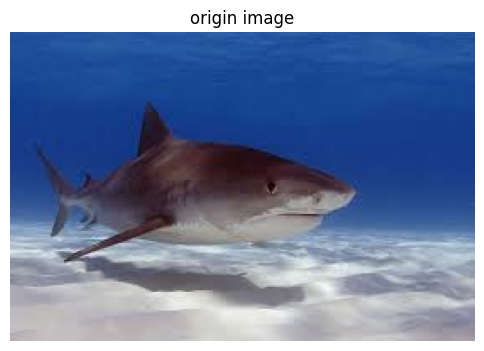

In [25]:
import torch
from torchvision import models, transforms
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQPqUIvVs_Q2veVfJXJgmU4HqJDedpaLTb5Vg&s'
response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert('RGB')

plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis('off')
plt.title('origin image')
plt.show()

In [26]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet 평균
                         std=[0.229, 0.224, 0.225])   # ImageNet 표준편차)
])

img_t = preprocess(img)
batch_t = torch.unsqueeze(img_t, 0)

model = models.alexnet(weights='AlexNet_Weights.IMAGENET1K_V1')
model.eval()

with torch.no_grad():
    output = model(batch_t)

prob = torch.nn.functional.softmax(output[0], dim=0)
top5_prob, top5_catid = torch.topk(prob, 5)

for i in range(top5_prob.size(0)):
    print(f"{imagenet_classes[top5_catid[i]]} : {top5_prob[i].item():.4f}")

tiger shark : 0.9962
hammerhead : 0.0020
great white shark : 0.0008
dugong : 0.0004
axolotl : 0.0002
